In [1]:
pip install matplotlib pillow opencv-python


Note: you may need to restart the kernel to use updated packages.


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("orvile/x-ray-baggage-anomaly-detection")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/x-ray-baggage-anomaly-detection


In [3]:
!pip install supervision

In [4]:
!pip install ultralytics

In [12]:
import pathlib
import warnings
warnings.filterwarnings('ignore')
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import cv2
import supervision as sv
from ultralytics import YOLO
import copy
from pathlib import Path
import torch
import torch.nn as nn
from torchvision.models.feature_extraction import create_feature_extractor
from collections import OrderedDict
from torchvision.ops.feature_pyramid_network import FeaturePyramidNetwork
from torchvision.models.detection.anchor_utils import AnchorGenerator
import torchvision
import torch.optim as optim
from tqdm import tqdm
from torchvision.ops import nms
import torchvision.transforms as T
from torchvision.ops.boxes import box_iou
from torch.utils.data import DataLoader
import xml.etree.ElementTree as ET
import torchvision
import cv2
import random
from PIL import Image
from collections import Counter
import torchvision.transforms.functional as F 
from collections import Counter
from IPython.display import Video
train_dir= pathlib.Path(path) / "train/images"
test_dir=pathlib.Path(path) / "test"
valid_dir= pathlib.Path(path) / "valid"
train_labels = pathlib.Path(path) / "train/labels"

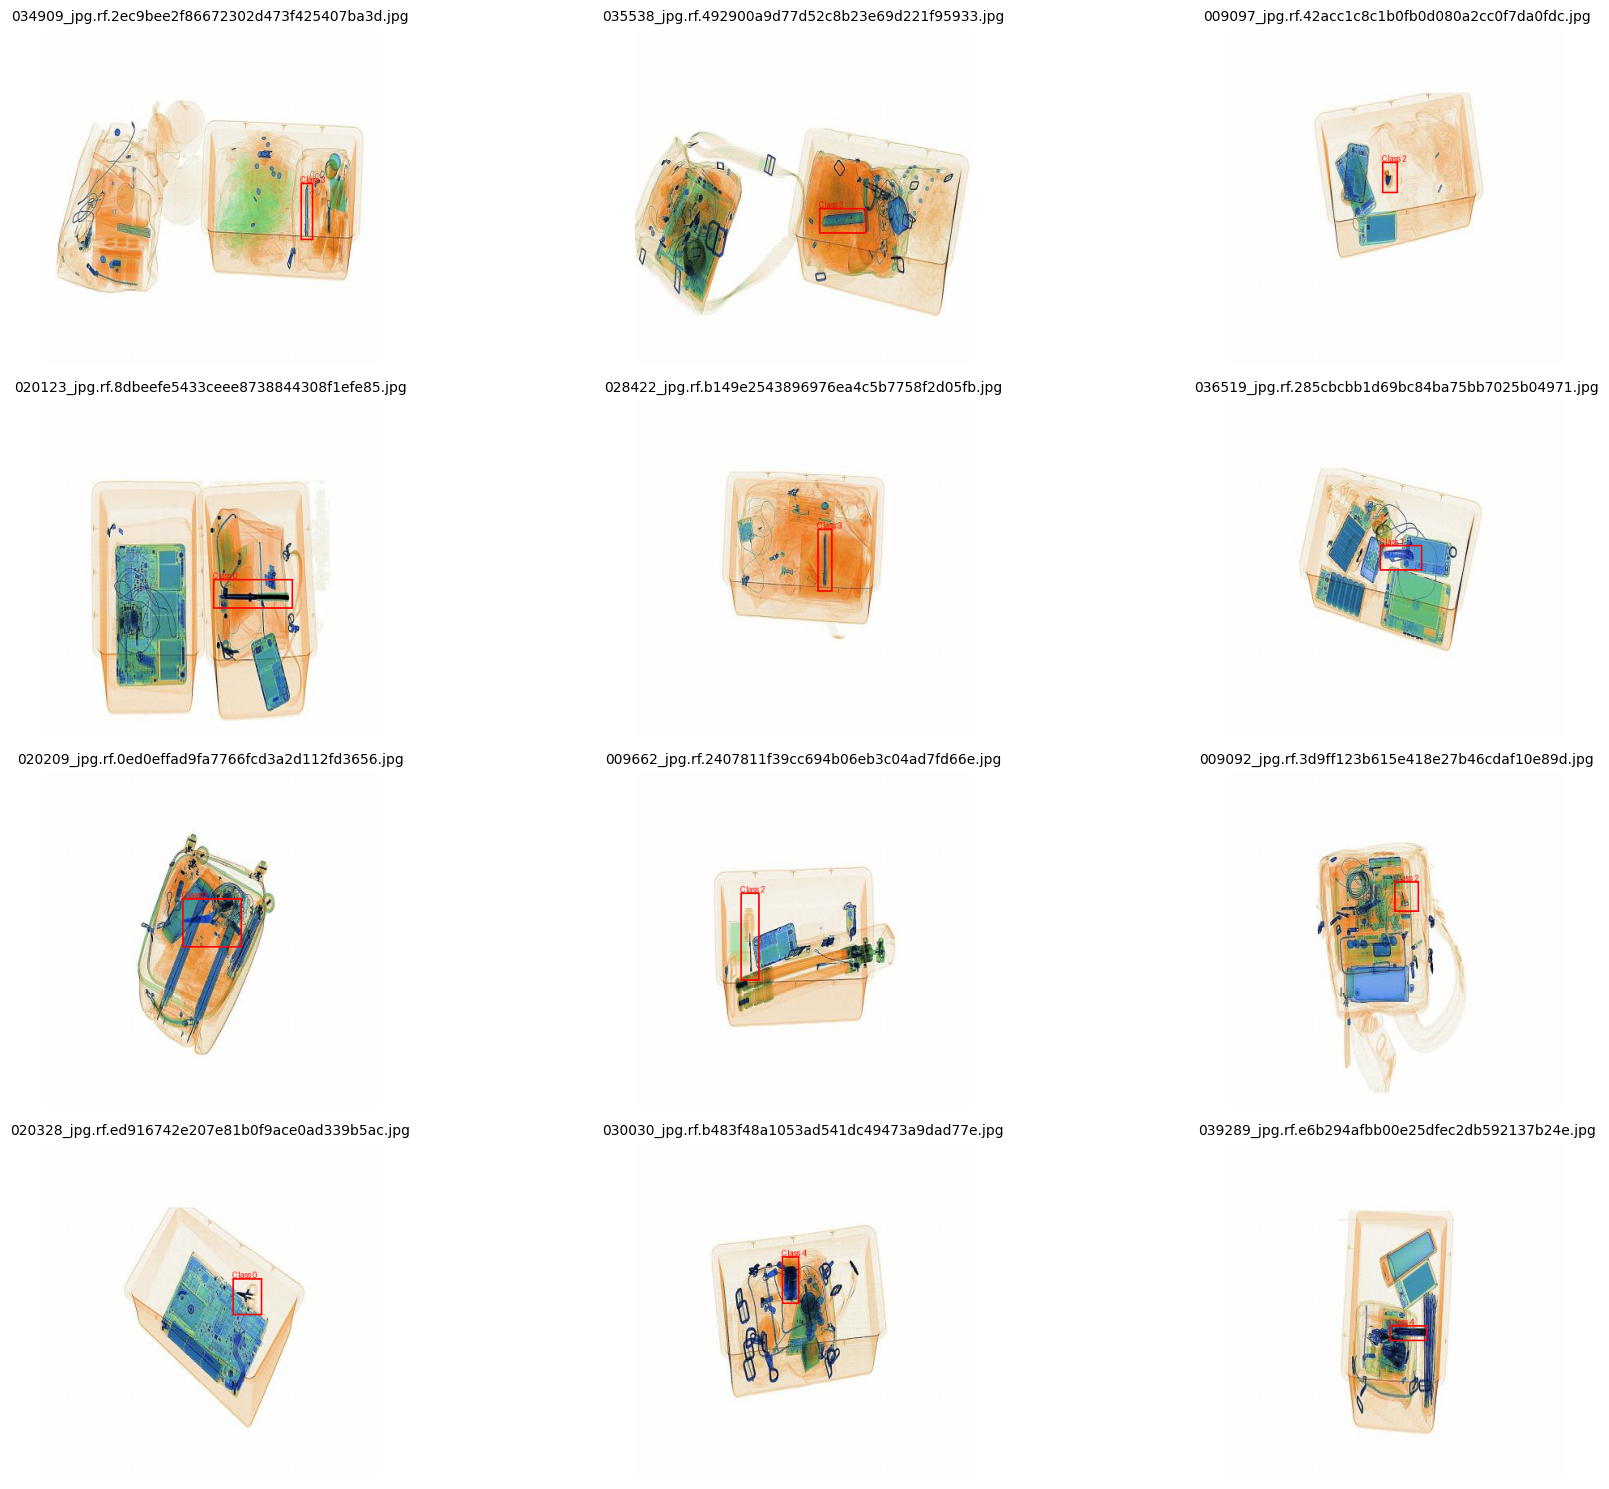

In [13]:
import random
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image, ImageDraw
import cv2
import os

# ========== Utilities ==========

def JPG_Name_To_TXT(image_name):
    return image_name.rsplit('.', 1)[0] + ".txt"

def get_image_dimensions(img_path):
    img = cv2.imread(str(img_path))
    if img is None:
        raise ValueError(f"❌ Could not read image: {img_path}")
    return img.shape[:2]

def TXT_To_BBOX(txt_path, img_height, img_width):
    bboxes = []
    with open(txt_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            class_id = int(parts[0])
            x_center, y_center, width, height = map(float, parts[1:])
            x_min = int((x_center - width / 2) * img_width)
            y_min = int((y_center - height / 2) * img_height)
            x_max = int((x_center + width / 2) * img_width)
            y_max = int((y_center + height / 2) * img_height)
            bboxes.append((x_min, y_min, x_max, y_max, class_id))
    return bboxes

# ========== Main Visualization Function ==========

# Point to the actual images directory
train_images = Path(train_dir)

def Plot_Random_Images_With_BBoxes():
    image_paths = list(train_images.glob("*.jpg")) + list(train_images.glob("*.png"))

    if len(image_paths) < 1:
        raise ValueError("No images found in the specified folder.")

    random_images = random.sample(image_paths, k=min(12, len(image_paths)))
    plt.figure(figsize=(20, 15))

    for i, img_path in enumerate(random_images):
        img = Image.open(img_path).convert("RGB")
        draw = ImageDraw.Draw(img)

        height, width = get_image_dimensions(img_path)

        txt_name = JPG_Name_To_TXT(img_path.name)
        # 🔥 FIXED: Get label from the "labels" folder
        txt_path = img_path.parent.parent / "labels" / txt_name

        if txt_path.exists():
            bboxes = TXT_To_BBOX(txt_path, height, width)
            for x_min, y_min, x_max, y_max, class_id in bboxes:
                draw.rectangle([x_min, y_min, x_max, y_max], outline="red", width=2)
                draw.text((x_min, y_min - 10), f"Class {class_id}", fill="red")
        else:
            print(f"⚠️ No label found for {img_path.name}, skipping boxes.")

        plt.subplot(4, 3, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(img_path.name, fontsize=10)
    
    plt.tight_layout()
    plt.show()

# ✅ Run the function
Plot_Random_Images_With_BBoxes()


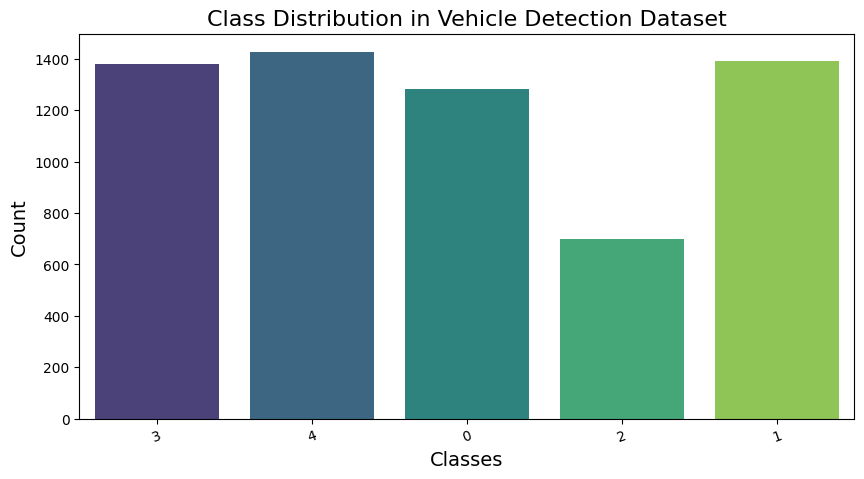

In [7]:
from collections import Counter
class_names= ['0', '1', '2', '3', '4']
def Count_Classes():
    """
    Reads all label files and counts the occurrences of each class.
    """
    class_counts = Counter()

    # Loop through all label files
    for txt_path in train_labels.iterdir():
        with open(txt_path, 'r') as f:
            lines = f.readlines()
            for line in lines:
                class_id = int(line.strip().split()[0])  # Extract class ID
                class_counts[class_names[class_id]] += 1  # Increment count

    # Plot countplot
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="viridis")
    plt.xlabel("Classes", fontsize=14)
    plt.ylabel("Count", fontsize=14)
    plt.title("Class Distribution in Vehicle Detection Dataset", fontsize=16)
    plt.xticks(rotation=20)  # Rotate labels for better readability
    plt.show()

Count_Classes()


image 1/1 /kaggle/input/x-ray-baggage-anomaly-detection/train/images/028280_jpg.rf.926d9705495a155bfa03fdb371c86628.jpg: 416x416 (no detections), 10.4ms
Speed: 1.4ms preprocess, 10.4ms inference, 70.4ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /kaggle/input/x-ray-baggage-anomaly-detection/train/images/029687_jpg.rf.211d1c46fc59fd76fbcb58f3ed64c647.jpg: 416x416 1 suitcase, 10.5ms
Speed: 0.7ms preprocess, 10.5ms inference, 150.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /kaggle/input/x-ray-baggage-anomaly-detection/train/images/028088_jpg.rf.7e8cc82e6f9b41a6dbc138b9d53e744d.jpg: 416x416 1 handbag, 1 suitcase, 11.3ms
Speed: 0.8ms preprocess, 11.3ms inference, 1.8ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /kaggle/input/x-ray-baggage-anomaly-detection/train/images/040504_jpg.rf.1ad63e8f12445f27d0d25fb490c9cf21.jpg: 416x416 (no detections), 10.4ms
Speed: 0.7ms preprocess, 10.4ms inference, 0.7ms postprocess per image at shape (1, 3, 41

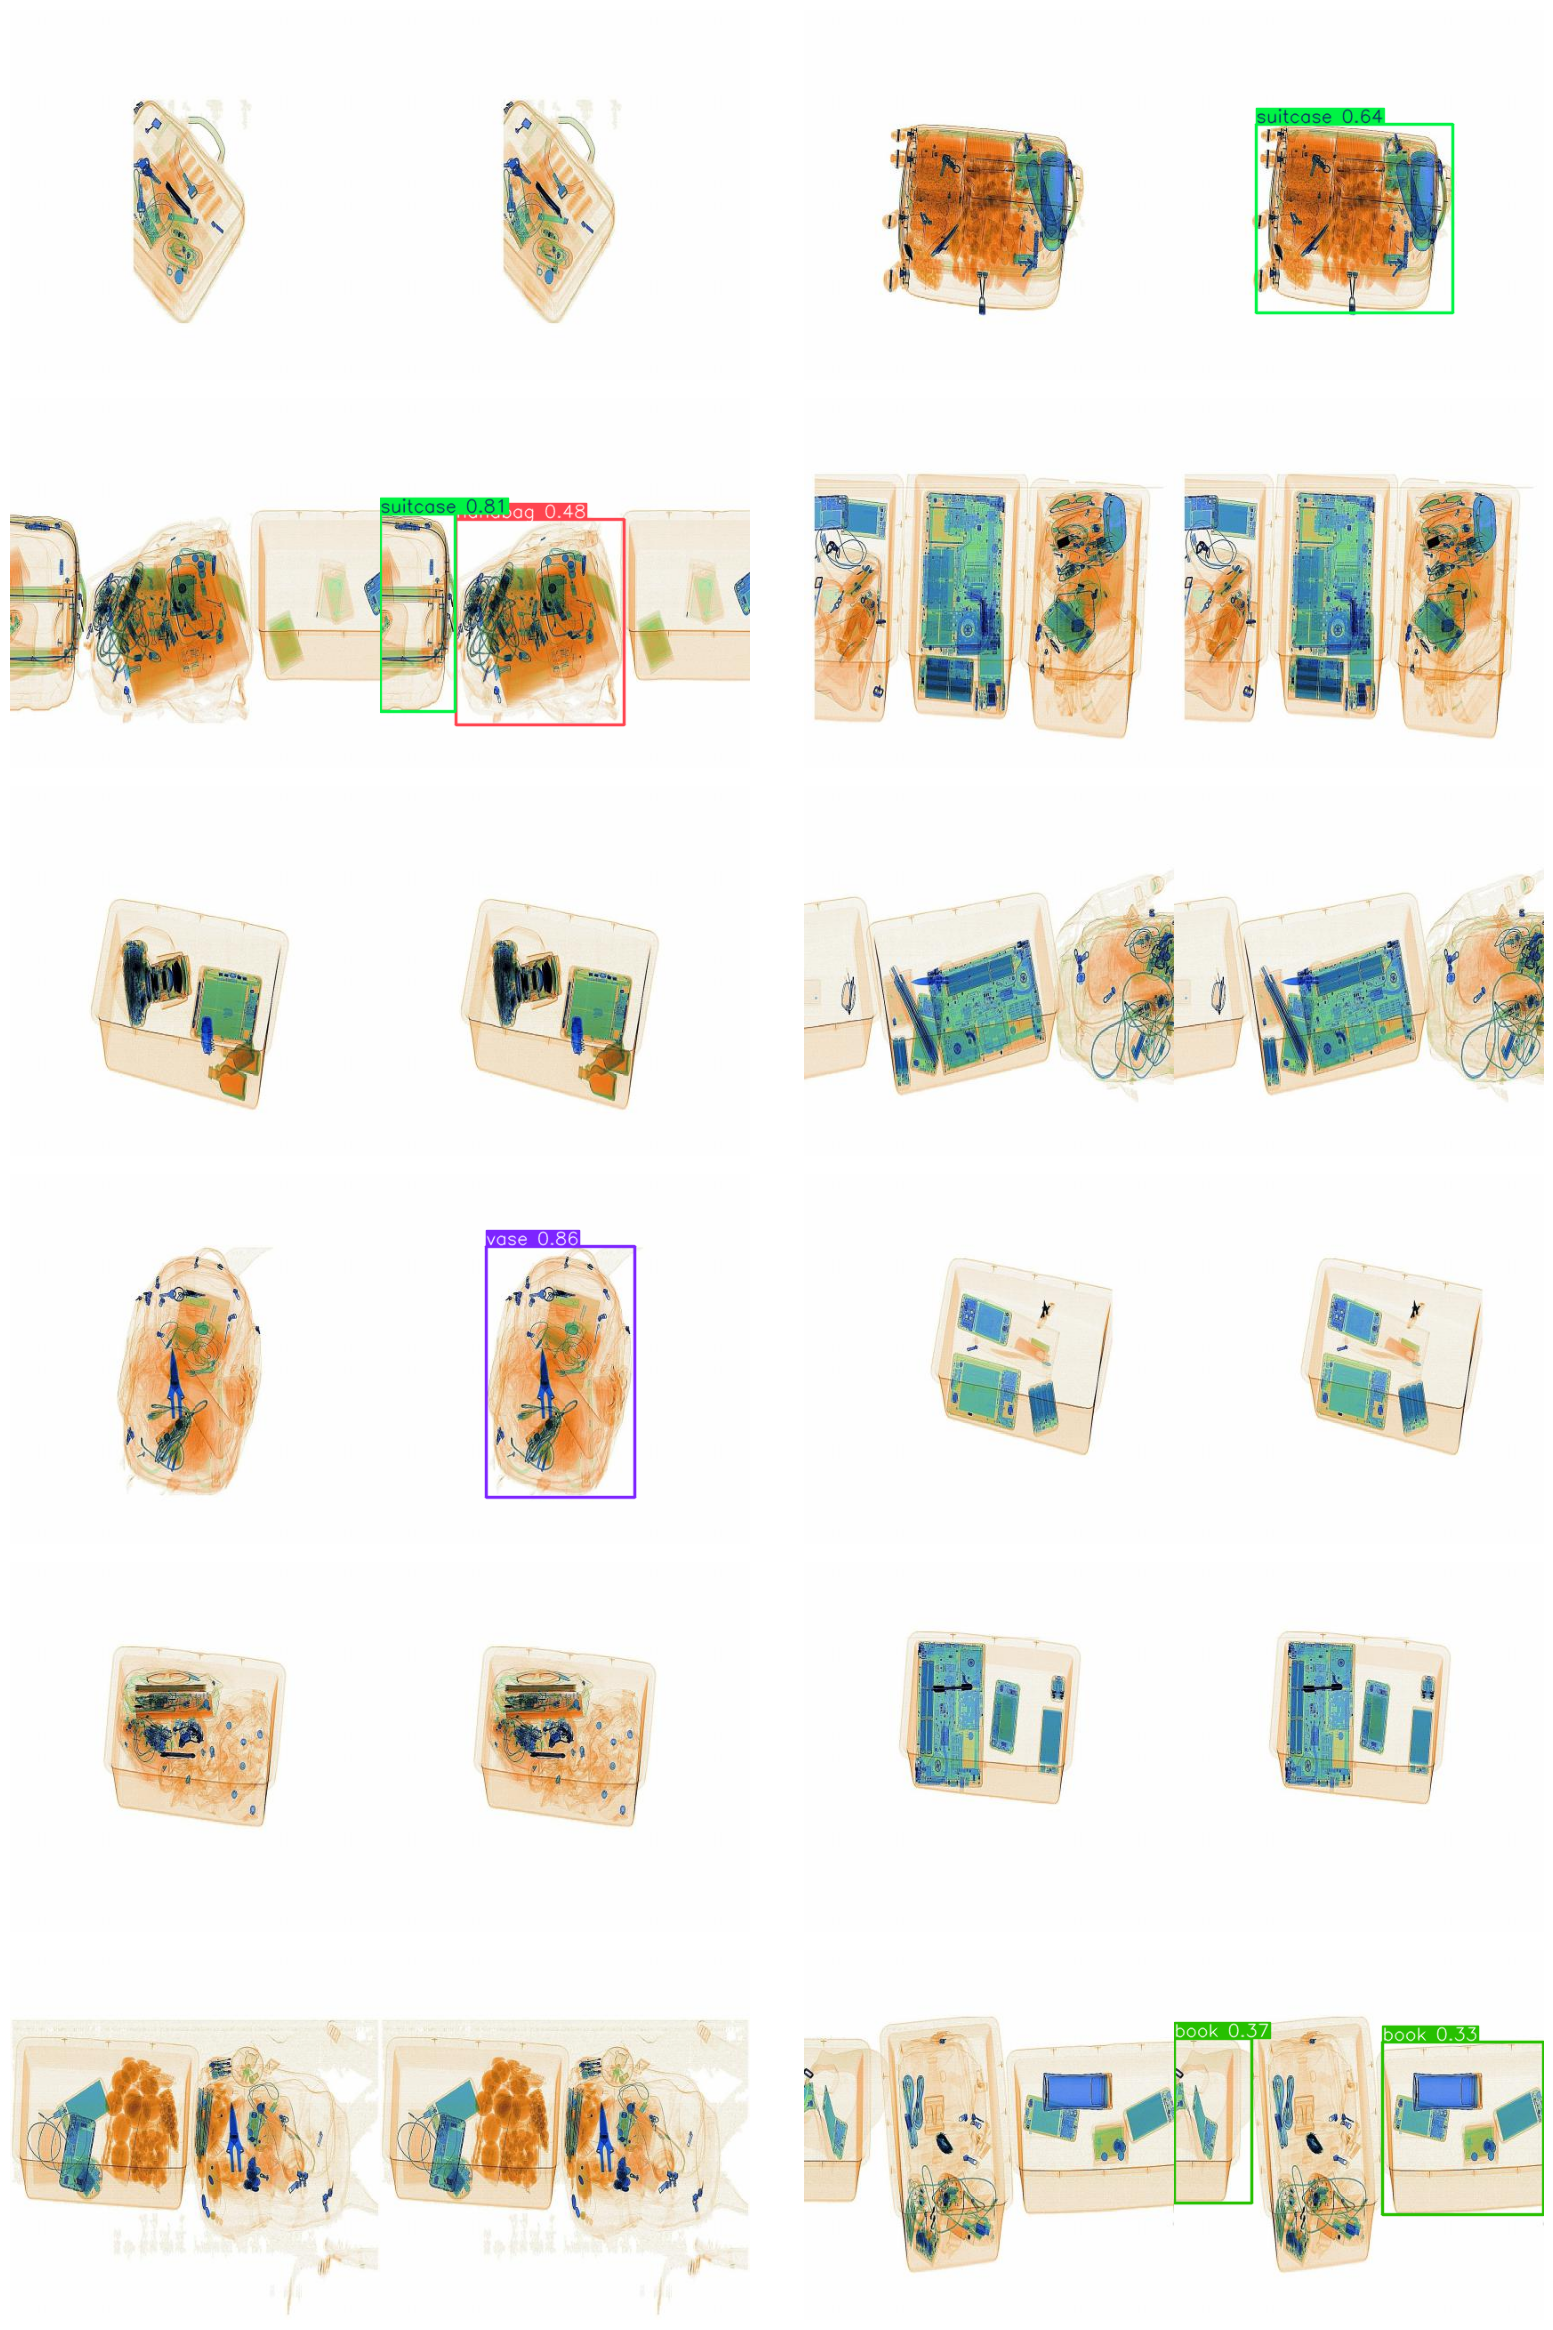

In [8]:
images_folder = train_dir

# Get image file list
image_files = [f for f in os.listdir(images_folder) if f.endswith(('.jpg', '.png', '.jpeg'))]

# Select 12 random images (since 6 columns × 2 images per column = 12 images)
random_images = random.sample(image_files, 12)

# Load YOLOv11 model
model = YOLO("yolo11s.pt")

# Set up plot layout (6 columns, 2 rows → each pair appears horizontally)
fig, axes = plt.subplots(6, 2, figsize=(20, 30))  # Large images, well-spaced
axes = axes.flatten()  # Flatten for easy indexing

# Process and plot images
for i, image_file in enumerate(random_images):
    image_path = os.path.join(images_folder, image_file)

    # Run YOLO prediction
    result_predict = model.predict(source=image_path, imgsz=(416))

    # Load original image
    original_image = Image.open(image_path)
    original_array = np.array(original_image)  # Convert to NumPy array

    # Get YOLO-predicted image
    for result in result_predict:
        plot = result.plot()
        plot = cv2.cvtColor(plot, cv2.COLOR_BGR2RGB)  # Convert to RGB format

    # Combine images horizontally
    combined_image = np.hstack((original_array, plot))

    # Display the combined image
    axes[i].imshow(combined_image)
    axes[i].axis('off')

# Adjust spacing to make images tight
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()

In [9]:
dataset_path = os.path.join(path)

# Set the path to the YAML file
yaml_file_path = os.path.join(dataset_path, 'data.yaml')

# Load and print the contents of the YAML file
with open(yaml_file_path, 'r') as file:
    yaml_content = yaml.load(file, Loader=yaml.FullLoader)
    print(yaml.dump(yaml_content, default_flow_style=False))

names:
- '0'
- '1'
- '2'
- '3'
- '4'
nc: 5
roboflow:
  license: CC BY 4.0
  project: x-ray-baggage-detection
  url: https://universe.roboflow.com/malek-mhnrl/x-ray-baggage-detection/dataset/1
  version: 1
  workspace: malek-mhnrl
test: ../test/images
train: ../train/images
val: ../valid/images



In [10]:
train_images_path = os.path.join(dataset_path, 'train', 'images')
valid_images_path = os.path.join(dataset_path, 'valid', 'images')

# Initialize counters for the number of images
num_train_images = 0
num_valid_images = 0

# Initialize sets to hold the unique sizes of images
train_image_sizes = set()
valid_image_sizes = set()

# Check train images sizes and count
for filename in os.listdir(train_images_path):
    if filename.endswith('.jpg'):  
        num_train_images += 1
        image_path = os.path.join(train_images_path, filename)
        with Image.open(image_path) as img:
            train_image_sizes.add(img.size)

# Check validation images sizes and count
for filename in os.listdir(valid_images_path):
    if filename.endswith('.jpg'): 
        num_valid_images += 1
        image_path = os.path.join(valid_images_path, filename)
        with Image.open(image_path) as img:
            valid_image_sizes.add(img.size)

# Print the results
print(f"Number of training images: {num_train_images}")
print(f"Number of validation images: {num_valid_images}")

# Check if all images in training set have the same size
if len(train_image_sizes) == 1:
    print(f"All training images have the same size: {train_image_sizes.pop()}")
else:
    print("Training images have varying sizes.")

# Check if all images in validation set have the same size
if len(valid_image_sizes) == 1:
    print(f"All validation images have the same size: {valid_image_sizes.pop()}")
else:
    print("Validation images have varying sizes.")

Number of training images: 6181
Number of validation images: 1766
All training images have the same size: (416, 416)
All validation images have the same size: (416, 416)


In [14]:
from ultralytics import YOLO

model = YOLO("yolov8m.pt")  # change model to medium

results = model.train(
    data=yaml_file_path,     # Path to the dataset config file
    epochs=45,
    imgsz=416,               # use 640 for better detection
    device=0,
    patience=20,             # Reduce patience to detect early overfitting
    batch=16,                # If model is larger, reduce batch size
    optimizer='AdamW',
    lr0=0.001,
    lrf=0.1,
    dropout=0.1,             # Smaller dropout for more stable training
    freeze=0,                # Don't freeze layers unless using transfer learning
    seed=42
)


Ultralytics 8.3.184 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/input/x-ray-baggage-anomaly-detection/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.1, dynamic=False, embed=None, epochs=45, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=0, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.1, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=20, perspective=0.0, plots=True,

train: Scanning /kaggle/input/x-ray-baggage-anomaly-detection/train/labels... 6181 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6181/6181 [00:14<00:00, 422.44it/s]


WARNING ⚠️ train: Cache directory /kaggle/input/x-ray-baggage-anomaly-detection/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.2±0.5 ms, read: 11.0±2.9 MB/s, size: 13.5 KB)


val: Scanning /kaggle/input/x-ray-baggage-anomaly-detection/valid/labels... 1766 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1766/1766 [00:04<00:00, 426.76it/s]

WARNING ⚠️ val: Cache directory /kaggle/input/x-ray-baggage-anomaly-detection/valid is not writeable, cache not saved.


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 45 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/45      6.08G      2.225      2.428       1.55          7        416: 100%|██████████| 387/387 [01:38<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:12<00:00,  4.37it/s]


                   all       1766       1766      0.391      0.487      0.462      0.181

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/45      6.38G       2.13      1.916      1.504          9        416: 100%|██████████| 387/387 [01:36<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:12<00:00,  4.45it/s]

                   all       1766       1766      0.528      0.552      0.534      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/45      6.81G       2.09      1.842      1.486          9        416: 100%|██████████| 387/387 [01:35<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:12<00:00,  4.41it/s]

                   all       1766       1766      0.507      0.458      0.495      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/45      6.87G      2.058      1.714      1.458         12        416: 100%|██████████| 387/387 [01:34<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:12<00:00,  4.44it/s]

                   all       1766       1766      0.712      0.476      0.539      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/45      6.94G      2.007       1.65      1.433          5        416: 100%|██████████| 387/387 [01:34<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:12<00:00,  4.44it/s]

                   all       1766       1766      0.622      0.572      0.616      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/45      7.01G      1.969      1.536      1.414         10        416: 100%|██████████| 387/387 [01:34<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:12<00:00,  4.45it/s]

                   all       1766       1766      0.747      0.625      0.698      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/45      5.94G      1.957      1.516      1.408          9        416: 100%|██████████| 387/387 [01:34<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:12<00:00,  4.42it/s]

                   all       1766       1766      0.738      0.601       0.68      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/45      5.94G      1.941      1.474      1.402          6        416: 100%|██████████| 387/387 [01:34<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:12<00:00,  4.40it/s]

                   all       1766       1766      0.682      0.637      0.676       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/45      5.94G      1.928      1.444      1.387         10        416: 100%|██████████| 387/387 [01:34<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:12<00:00,  4.43it/s]

                   all       1766       1766      0.764      0.641      0.724      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/45      6.03G      1.913      1.396      1.379          4        416: 100%|██████████| 387/387 [01:34<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:12<00:00,  4.41it/s]

                   all       1766       1766      0.718      0.646      0.714      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/45       6.4G      1.901      1.391      1.372         12        416: 100%|██████████| 387/387 [01:34<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:12<00:00,  4.42it/s]

                   all       1766       1766      0.789      0.682      0.765      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/45      6.45G      1.878      1.329       1.36          7        416: 100%|██████████| 387/387 [01:34<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:12<00:00,  4.41it/s]

                   all       1766       1766      0.802      0.676      0.763      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/45      6.53G      1.864      1.322      1.354          4        416: 100%|██████████| 387/387 [01:34<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:12<00:00,  4.42it/s]

                   all       1766       1766      0.745      0.682      0.743      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/45       6.6G      1.868      1.273      1.352          4        416: 100%|██████████| 387/387 [01:34<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:12<00:00,  4.34it/s]

                   all       1766       1766      0.813      0.717      0.783      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/45      7.03G      1.866      1.275      1.347         10        416: 100%|██████████| 387/387 [01:34<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:12<00:00,  4.33it/s]

                   all       1766       1766      0.749       0.69      0.741        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/45      7.08G      1.853      1.274      1.346         10        416: 100%|██████████| 387/387 [01:34<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:12<00:00,  4.44it/s]

                   all       1766       1766      0.813      0.708      0.781      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/45      7.16G      1.843      1.226      1.331          8        416: 100%|██████████| 387/387 [01:34<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:12<00:00,  4.33it/s]

                   all       1766       1766      0.853      0.754      0.818      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/45      7.22G      1.838      1.229      1.332         10        416: 100%|██████████| 387/387 [01:34<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:12<00:00,  4.41it/s]

                   all       1766       1766      0.844      0.731      0.802      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/45      5.85G       1.82      1.205      1.331          5        416: 100%|██████████| 387/387 [01:34<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:12<00:00,  4.45it/s]

                   all       1766       1766        0.8      0.772      0.797      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/45      6.06G       1.82      1.175      1.329          6        416: 100%|██████████| 387/387 [01:34<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:12<00:00,  4.48it/s]

                   all       1766       1766       0.84       0.73      0.806      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/45      6.06G      1.805      1.181      1.315          5        416: 100%|██████████| 387/387 [01:34<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:12<00:00,  4.47it/s]

                   all       1766       1766      0.852      0.761      0.841       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/45      6.06G      1.807      1.168      1.315         15        416: 100%|██████████| 387/387 [01:34<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:12<00:00,  4.34it/s]

                   all       1766       1766      0.854      0.781      0.834      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/45      6.28G        1.8      1.145      1.304          6        416: 100%|██████████| 387/387 [01:35<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:12<00:00,  4.32it/s]

                   all       1766       1766      0.841      0.781      0.835      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/45      6.32G      1.784      1.141      1.305          7        416: 100%|██████████| 387/387 [01:35<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:12<00:00,  4.33it/s]

                   all       1766       1766      0.804      0.769        0.8      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/45      6.39G      1.766      1.106      1.293          4        416: 100%|██████████| 387/387 [01:34<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:12<00:00,  4.48it/s]

                   all       1766       1766      0.846      0.787      0.832      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/45      6.54G      1.776      1.123      1.304          4        416: 100%|██████████| 387/387 [01:34<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:12<00:00,  4.47it/s]

                   all       1766       1766      0.851        0.8      0.846      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/45       6.7G      1.765      1.088      1.295          8        416: 100%|██████████| 387/387 [01:34<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:12<00:00,  4.37it/s]

                   all       1766       1766      0.852       0.78      0.843      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/45      6.84G       1.76      1.095      1.293          4        416: 100%|██████████| 387/387 [01:34<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:12<00:00,  4.43it/s]

                   all       1766       1766      0.863      0.803       0.86       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/45         7G      1.758      1.077      1.282          5        416: 100%|██████████| 387/387 [01:34<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:12<00:00,  4.47it/s]

                   all       1766       1766      0.837      0.776      0.832      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/45      7.15G      1.734      1.068      1.277          7        416: 100%|██████████| 387/387 [01:34<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:12<00:00,  4.49it/s]

                   all       1766       1766      0.856      0.785      0.839      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/45      5.99G      1.749      1.065      1.285          9        416: 100%|██████████| 387/387 [01:34<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:12<00:00,  4.50it/s]

                   all       1766       1766      0.859      0.792       0.84      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/45      5.99G      1.734      1.028      1.272         10        416: 100%|██████████| 387/387 [01:34<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:12<00:00,  4.48it/s]

                   all       1766       1766      0.874      0.803      0.858      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/45      5.99G      1.727      1.027      1.267          9        416: 100%|██████████| 387/387 [01:34<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:12<00:00,  4.48it/s]

                   all       1766       1766      0.886      0.823      0.873      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/45      6.04G      1.718      1.014      1.261          6        416: 100%|██████████| 387/387 [01:34<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:12<00:00,  4.49it/s]

                   all       1766       1766      0.858      0.811      0.867      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/45      6.12G      1.704      1.004      1.264          7        416: 100%|██████████| 387/387 [01:34<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:12<00:00,  4.49it/s]

                   all       1766       1766      0.846      0.789      0.829      0.359


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/45      6.37G      1.693     0.9022      1.377          5        416: 100%|██████████| 387/387 [01:34<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:12<00:00,  4.49it/s]

                   all       1766       1766       0.86      0.831      0.873      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/45      6.45G       1.68     0.8822      1.364          5        416: 100%|██████████| 387/387 [01:34<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:12<00:00,  4.48it/s]

                   all       1766       1766      0.871      0.837       0.87      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/45      6.54G      1.674     0.8616      1.356          5        416: 100%|██████████| 387/387 [01:34<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:12<00:00,  4.49it/s]

                   all       1766       1766      0.884      0.846      0.885      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/45      6.82G      1.653     0.8404      1.352          5        416: 100%|██████████| 387/387 [01:34<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:12<00:00,  4.49it/s]

                   all       1766       1766      0.866      0.835      0.874      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/45      6.88G      1.647     0.8296      1.349          5        416: 100%|██████████| 387/387 [01:34<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:12<00:00,  4.46it/s]

                   all       1766       1766      0.885      0.841      0.876      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/45         7G      1.639     0.8221      1.345          5        416: 100%|██████████| 387/387 [01:34<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:12<00:00,  4.49it/s]

                   all       1766       1766       0.88      0.844      0.875      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/45      7.14G       1.63      0.816      1.332          5        416: 100%|██████████| 387/387 [01:34<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:12<00:00,  4.48it/s]

                   all       1766       1766      0.876      0.838      0.879      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/45      7.43G      1.624     0.8032      1.333          5        416: 100%|██████████| 387/387 [01:34<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:12<00:00,  4.49it/s]

                   all       1766       1766      0.873      0.847      0.882       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/45      6.04G      1.605     0.7922       1.32          5        416: 100%|██████████| 387/387 [01:34<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:12<00:00,  4.47it/s]

                   all       1766       1766      0.887       0.84      0.882      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/45      6.04G      1.601     0.7734       1.32          5        416: 100%|██████████| 387/387 [01:34<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:12<00:00,  4.49it/s]

                   all       1766       1766      0.875      0.841      0.884       0.41



45 epochs completed in 1.356 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 52.0MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.184 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,842,655 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:13<00:00,  4.15it/s]


                   all       1766       1766      0.887       0.84      0.883      0.411
                     0        391        391      0.989       0.98      0.983      0.533
                     1        389        389      0.881      0.879      0.933      0.426
                     2        225        225      0.828      0.577      0.697      0.261
                     3        366        366      0.846      0.857      0.869      0.418
                     4        395        395       0.89      0.909      0.933      0.416
Speed: 0.1ms preprocess, 4.4ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/train2


In [18]:
# Define the path to the directory
post_training_files_path = '/kaggle/working/runs/detect/train2'

# List the files in the directory
!ls {post_training_files_path}

args.yaml			 labels.jpg	       train_batch2.jpg
BoxF1_curve.png			 results.csv	       val_batch0_labels.jpg
BoxP_curve.png			 results.png	       val_batch0_pred.jpg
BoxPR_curve.png			 train_batch0.jpg      val_batch1_labels.jpg
BoxR_curve.png			 train_batch13545.jpg  val_batch1_pred.jpg
confusion_matrix_normalized.png  train_batch13546.jpg  val_batch2_labels.jpg
confusion_matrix.png		 train_batch13547.jpg  val_batch2_pred.jpg
labels_correlogram.jpg		 train_batch1.jpg      weights


In [19]:
def plot_learning_curve(df, train_loss_col, val_loss_col, title):
    plt.figure(figsize=(12, 5))
    sns.lineplot(data=df, x='epoch', y=train_loss_col, label='Train Loss', color='navy', linestyle='-', linewidth=2)
    sns.lineplot(data=df, x='epoch', y=val_loss_col, label='Validation Loss', color='green', linestyle='--', linewidth=2)
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

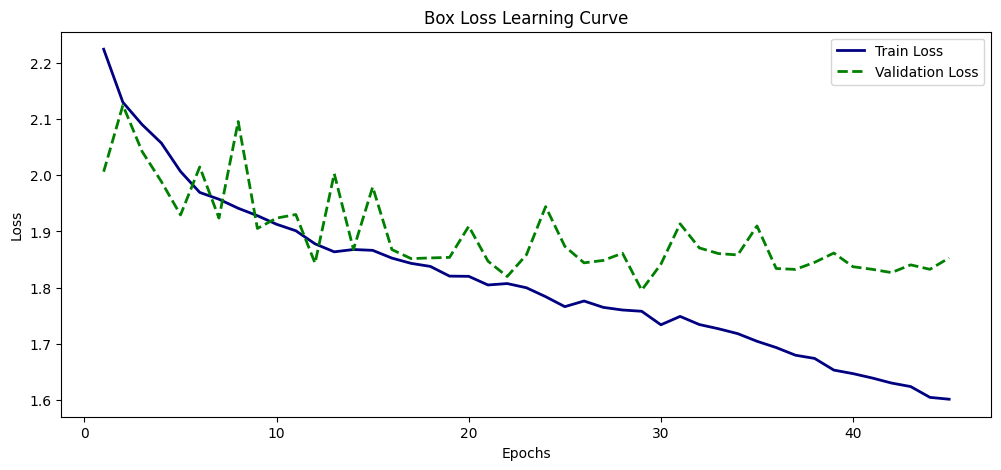

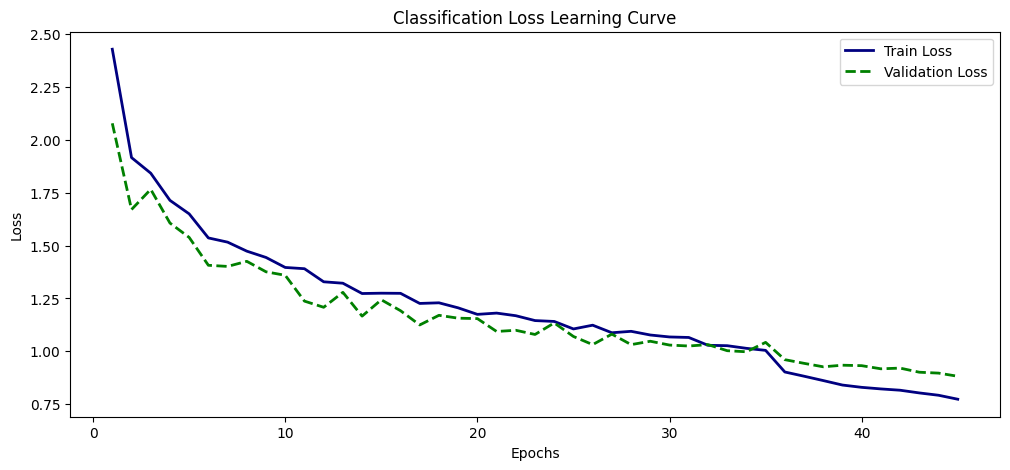

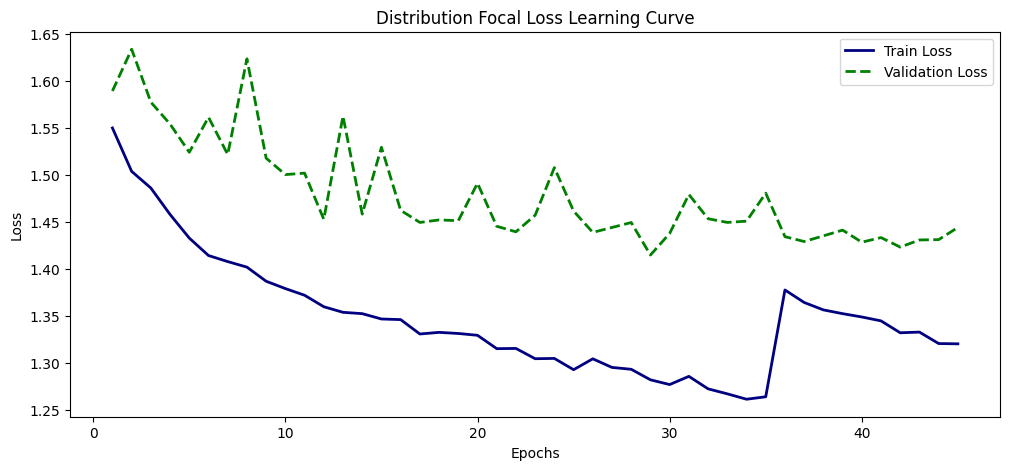

In [20]:
results_csv_path = os.path.join(post_training_files_path, 'results.csv')

# Load the CSV file from the constructed path into a pandas DataFrame
df = pd.read_csv(results_csv_path)

# Remove any leading whitespace from the column names
df.columns = df.columns.str.strip()

# Plot the learning curves for each loss
plot_learning_curve(df, 'train/box_loss', 'val/box_loss', 'Box Loss Learning Curve')
plot_learning_curve(df, 'train/cls_loss', 'val/cls_loss', 'Classification Loss Learning Curve')
plot_learning_curve(df, 'train/dfl_loss', 'val/dfl_loss', 'Distribution Focal Loss Learning Curve')

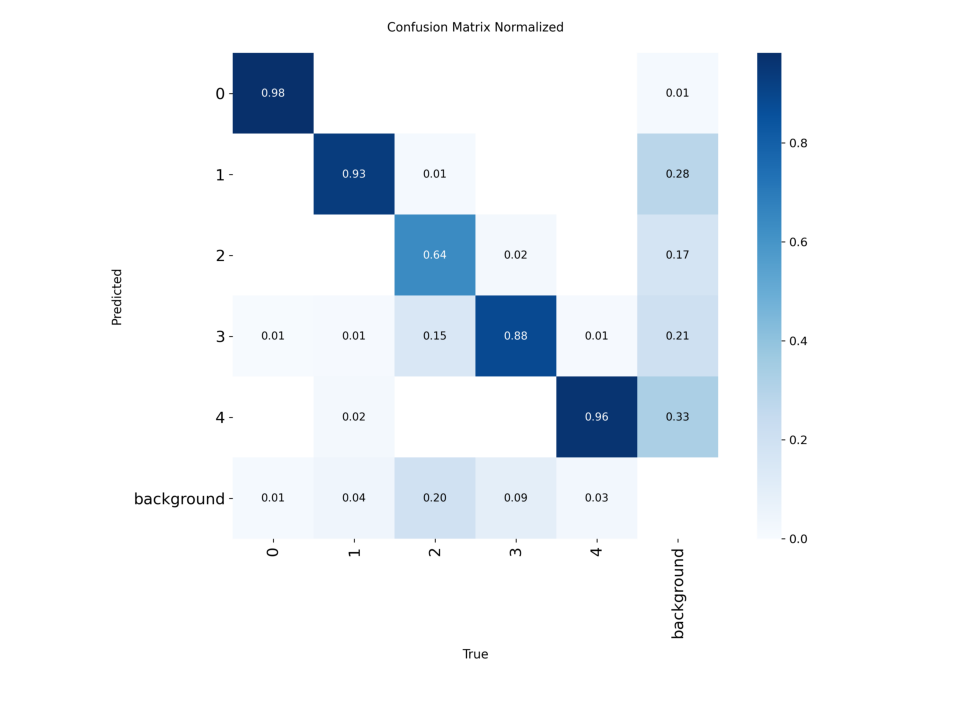

In [21]:
confusion_matrix_path = os.path.join(post_training_files_path, 'confusion_matrix_normalized.png')

# Read the image using cv2
cm_img = cv2.imread(confusion_matrix_path)

# Convert the image from BGR to RGB color space for accurate color representation with matplotlib
cm_img = cv2.cvtColor(cm_img, cv2.COLOR_BGR2RGB)

# Display the image
plt.figure(figsize=(10, 10), dpi=120)
plt.imshow(cm_img)
plt.axis('off') 
plt.show()

In [22]:
# Construct the path to the best model weights file using os.path.join
best_model_path_yolo_detect = os.path.join(post_training_files_path, 'weights/best.pt')

# Load the best model weights into the YOLO model
best_model_yolo_detect = YOLO(best_model_path_yolo_detect)

# Validate the best model using the validation set with default parameters
metrics_yolo_detect = best_model_yolo_detect.val(split='val')

Ultralytics 8.3.184 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,842,655 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access ✅ (ping: 0.9±1.2 ms, read: 12.9±3.1 MB/s, size: 14.8 KB)


val: Scanning /kaggle/input/x-ray-baggage-anomaly-detection/valid/labels... 1766 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1766/1766 [00:04<00:00, 385.59it/s]

WARNING ⚠️ val: Cache directory /kaggle/input/x-ray-baggage-anomaly-detection/valid is not writeable, cache not saved.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 111/111 [00:22<00:00,  4.99it/s]


                   all       1766       1766      0.887       0.84      0.883      0.412
                     0        391        391      0.989       0.98      0.983      0.535
                     1        389        389      0.883      0.879      0.934      0.428
                     2        225        225      0.828      0.577      0.695      0.263
                     3        366        366      0.846      0.857      0.869      0.418
                     4        395        395      0.888      0.909      0.933      0.415
Speed: 0.2ms preprocess, 9.6ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/detect/val


In [24]:
trained_model = YOLO("runs/detect/train2/weights/best.pt")

# Export to ONNX format
trained_model.export(format="onnx")

Ultralytics 8.3.184 🚀 Python-3.11.11 torch-2.6.0+cu124 CPU (Intel Xeon 2.00GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/
Model summary (fused): 92 layers, 25,842,655 parameters, 0 gradients, 78.7 GFLOPs

PyTorch: starting from 'runs/detect/train2/weights/best.pt' with input shape (1, 3, 416, 416) BCHW and output shape(s) (1, 9, 3549) (49.6 MB)
requirements: Ultralytics requirements ['onnxslim>=0.1.59', 'onnxruntime-gpu'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 4.7s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.65...
ONNX: export success ✅ 8.2s, saved as 'runs/detect/train2/weights/best.onnx' (98.7 MB)

Export complete (9.3s)
Results saved to /kaggle/working/runs/detect/train2/weights
Predict:         yolo predict task=detect model=r

'runs/detect/train2/weights/best.onnx'


image 1/1 /kaggle/input/x-ray-baggage-anomaly-detection/test/images/032042_jpg.rf.a5860590cefe3183c34f5343d9958a06.jpg: 416x416 1 3, 21.8ms
Speed: 0.9ms preprocess, 21.8ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 416)


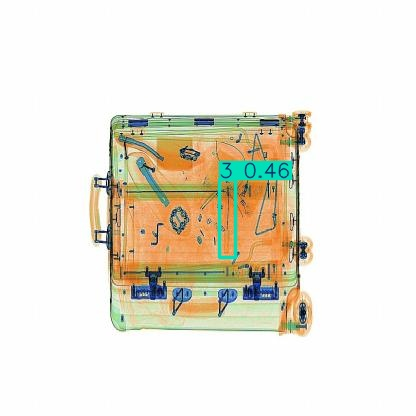


image 1/1 /kaggle/input/x-ray-baggage-anomaly-detection/test/images/039047_jpg.rf.26cf4813ba318590aaf27cfee561c618.jpg: 416x416 1 1, 21.8ms
Speed: 0.8ms preprocess, 21.8ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 416)


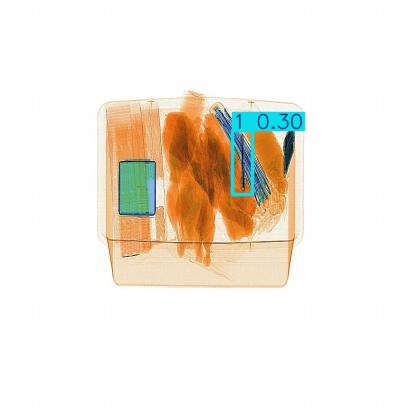


image 1/1 /kaggle/input/x-ray-baggage-anomaly-detection/test/images/024744_jpg.rf.0b41b5421e00b3282f1f139dc6765b14.jpg: 416x416 1 0, 21.8ms
Speed: 0.7ms preprocess, 21.8ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 416)


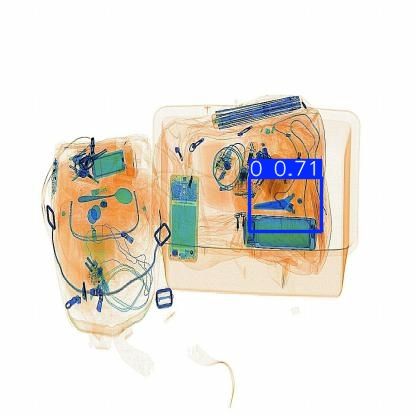


image 1/1 /kaggle/input/x-ray-baggage-anomaly-detection/test/images/027684_jpg.rf.ef0e4558e123dca8aed7e6055381e4da.jpg: 416x416 1 1, 19.9ms
Speed: 0.7ms preprocess, 19.9ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 416)


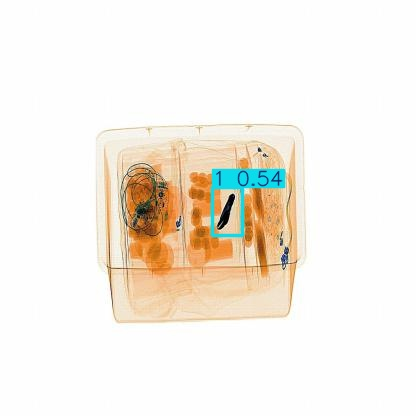


image 1/1 /kaggle/input/x-ray-baggage-anomaly-detection/test/images/023692_jpg.rf.09d8390aecbb573e838353648aa5073c.jpg: 416x416 1 0, 19.2ms
Speed: 0.6ms preprocess, 19.2ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 416)


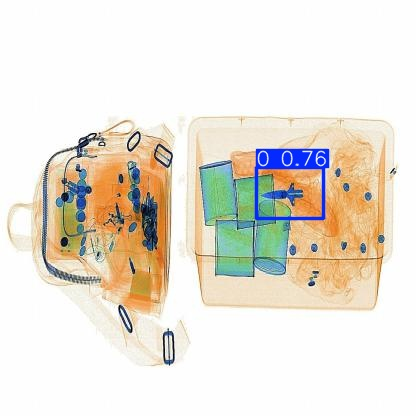


image 1/1 /kaggle/input/x-ray-baggage-anomaly-detection/test/images/020107_jpg.rf.67ed8215e0958280bf89805ee397767b.jpg: 416x416 1 0, 19.2ms
Speed: 0.7ms preprocess, 19.2ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 416)


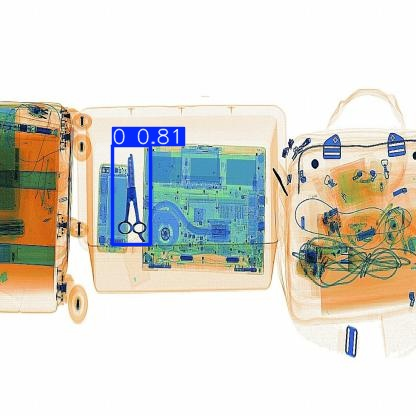


image 1/1 /kaggle/input/x-ray-baggage-anomaly-detection/test/images/027231_jpg.rf.df560bea72b2e834332b699d6446b23c.jpg: 416x416 1 1, 18.9ms
Speed: 0.6ms preprocess, 18.9ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 416)


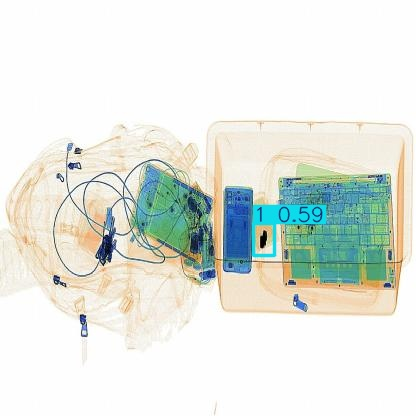


image 1/1 /kaggle/input/x-ray-baggage-anomaly-detection/test/images/017109_jpg.rf.ec07be4b6c4751c7400ae4dbc991975f.jpg: 416x416 1 0, 18.9ms
Speed: 0.6ms preprocess, 18.9ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 416)


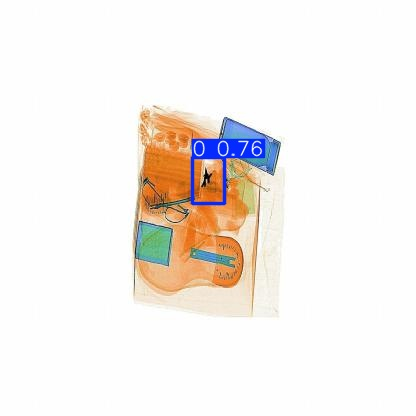


image 1/1 /kaggle/input/x-ray-baggage-anomaly-detection/test/images/036018_jpg.rf.b5175739856ba3eac1ed96d63c32f329.jpg: 416x416 2 3s, 18.8ms
Speed: 0.6ms preprocess, 18.8ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 416)


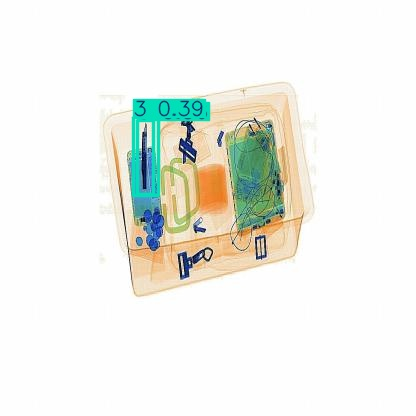


image 1/1 /kaggle/input/x-ray-baggage-anomaly-detection/test/images/039014_jpg.rf.44668808b4356acf3feda3242ef5b7d9.jpg: 416x416 1 3, 14.8ms
Speed: 0.6ms preprocess, 14.8ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 416)


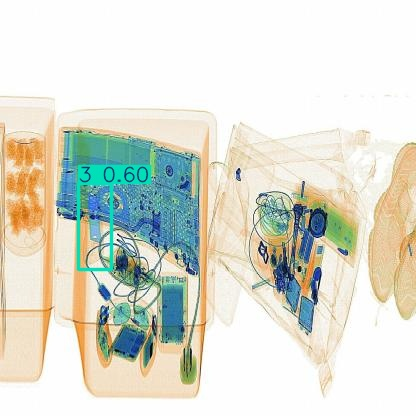

In [25]:
import os
import random
from IPython.display import display, Image  # ✅ Correct imports

# Avoid using 'dir' as a variable name
test_dir = os.path.join(path, "test","images")

def display_results(model, img_dir, num_images=5):
    images = [f for f in os.listdir(img_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    if len(images) == 0:
        print("No images found in directory:", img_dir)
        return
    
    num_images = 10  # avoid sampling more than available
    sample_images = random.sample(images, num_images)

    save_dir = 'runs/detect/exp'
    os.makedirs(save_dir, exist_ok=True)

    for image_name in sample_images:
        image_path = os.path.join(img_dir, image_name)
        results = model(image_path)
        for result in results:
            result.plot(save=True, filename=os.path.join(save_dir, os.path.basename(result.path)))
            result_image_path = os.path.join(save_dir, os.path.basename(result.path))
            display(Image(filename=result_image_path))


# Now this should work without error
display_results(model, test_dir)
